## 1. EDA for Sticker Forecasting  

In [1]:
# Стандартные библиотеки
from math import sqrt

# Научные вычисления и обработка данных
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

# Визуализация
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt

# Машинное обучение и предобработка
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

Initial exploratory analysis focuses on:  
- **Data structure examination** (columns, dtypes, timespan)  
- **Missing value detection** (NaN distribution patterns)  
- **Key gap identification** (sticker types with highest NaN rates, missing sales records)  
- **Data completeness validation** for time series continuity  

In [3]:
df = pd.read_csv("./data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


As we can see here there are NaN values in a **num_sold** column. Let's watch the disrtibution of it by types of stickers and countries where this stickers were sold. 

In [ ]:
table_data = []

print(f"\n Total missing sales records: {df['num_sold'].isna().sum()}")
for product in df["product"].unique():
    product_df = df[df["product"] == product]
    missing = product_df['num_sold'].isna().sum()
    total = len(product_df)
    ratio = missing / total
    
    table_data.append([
        product[:28],
        missing,
        total,
        f"{ratio:.2%}"
    ])

print(tabulate(
    table_data,
    headers=["Sticker", "Missing", "Total", "Ratio"],
    tablefmt="pretty",
    stralign="left",
    numalign="center"
))


 Total missing sales records: 8871
+--------------------+---------+-------+--------+
| Sticker            | Missing | Total | Ratio  |
+--------------------+---------+-------+--------+
| Holographic Goose  | 8806    | 46026 | 19.13% |
| Kaggle             | 0       | 46026 | 0.00%  |
| Kaggle Tiers       | 0       | 46026 | 0.00%  |
| Kerneler           | 64      | 46026 | 0.14%  |
| Kerneler Dark Mode | 1       | 46026 | 0.00%  |
+--------------------+---------+-------+--------+


The Holographic Goose sticker exhibits the highest frequency of NaN values, necessitating targeted data gap analysis. To address this, we will first examine its temporal distribution patterns, then evaluate mitigation strategies through outlier detection or statistical imputation methods.

In [6]:
na_stores = df[df.isna().any(axis=1)]['store'].unique()

print(f"\n Missing Values Detected in {len(na_stores)} Unique Stores:")
print("━"*40)
print("• " + "\n• ".join(na_stores))
print("━"*40)
print(f"Total Affected Stores: {len(na_stores)}/{len(df['store'].unique())}")


 Missing Values Detected in 3 Unique Stores:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Discount Stickers
• Stickers for Less
• Premium Sticker Mart
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total Affected Stores: 3/3


Let's plot sales distribution to understand why there are so many NaN values in Holographic goose stickers.

In [13]:
def plot_sales_trends(
    data: pd.DataFrame,
    entities: list[str],
    value_column: str = 'num_sold',
    group_key: str = 'country'
) -> None:
    """
    Visualize sales trends with moving averages and peak markers.
    
    Parameters:
        data (pd.DataFrame): Source dataframe with time series data
        entities (list): List of countries/stores to visualize
        value_column (str): Column name containing sales values
        group_key (str): Grouping dimension ('country' or 'store')
    
    Returns:
        None: Displays matplotlib visualization
    """

    num_plots = len(entities)
    fig, axes = plt.subplots(
        nrows=num_plots,
        ncols=1,
        figsize=(16, 5 * num_plots),
        squeeze=False,
        facecolor='#f5f5f5'
    )
    
    plt.suptitle('Sales Performance Analysis', y=1.02, fontsize=18, fontweight='bold')
    
    for idx, entity in enumerate(entities):
        ax = axes[idx][0]
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_color('#404040')
            spine.set_linewidth(1.5)

        entity_data = data[data[group_key] == entity]
        entity_data = entity_data.sort_values('date')
        entity_data = entity_data.copy()
        
        ax.plot(entity_data['date'], entity_data[value_column], 
                marker='o', linestyle='-', linewidth=1.5, markersize=4,
                color='#2c7bb6', alpha=0.7, label='Daily Sales')
        
        trend_values = entity_data[value_column].rolling(
            window=30, min_periods=1, center=True
        ).mean()
        ax.plot(entity_data['date'], trend_values,
                linestyle='--', linewidth=2.5, 
                color='#d7191c', label='30-Day Trend')
        
        peak_value = entity_data[value_column].max()
        peak_date = entity_data.loc[entity_data[value_column].idxmax(), 'date']
        ax.scatter(peak_date, peak_value, color='#fdae61', 
                   s=150, zorder=5, label=f'Peak: {peak_value:,}')
        
        ax.set_title(f'{group_key.title()}: {entity}', fontsize=14, pad=12)
        ax.set_xlabel('Date', fontsize=12, labelpad=10)
        ax.set_ylabel('Units Sold', fontsize=12, labelpad=10)
        ax.grid(True, alpha=0.3)
        
        legend = ax.legend(
            loc='upper right',
            bbox_to_anchor=(1.18, 1),
            frameon=True,
            framealpha=1,
            edgecolor='#404040',
            fontsize=10
        )
        legend.get_frame().set_linewidth(1.5)
        
        ax.tick_params(axis='x', rotation=35, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

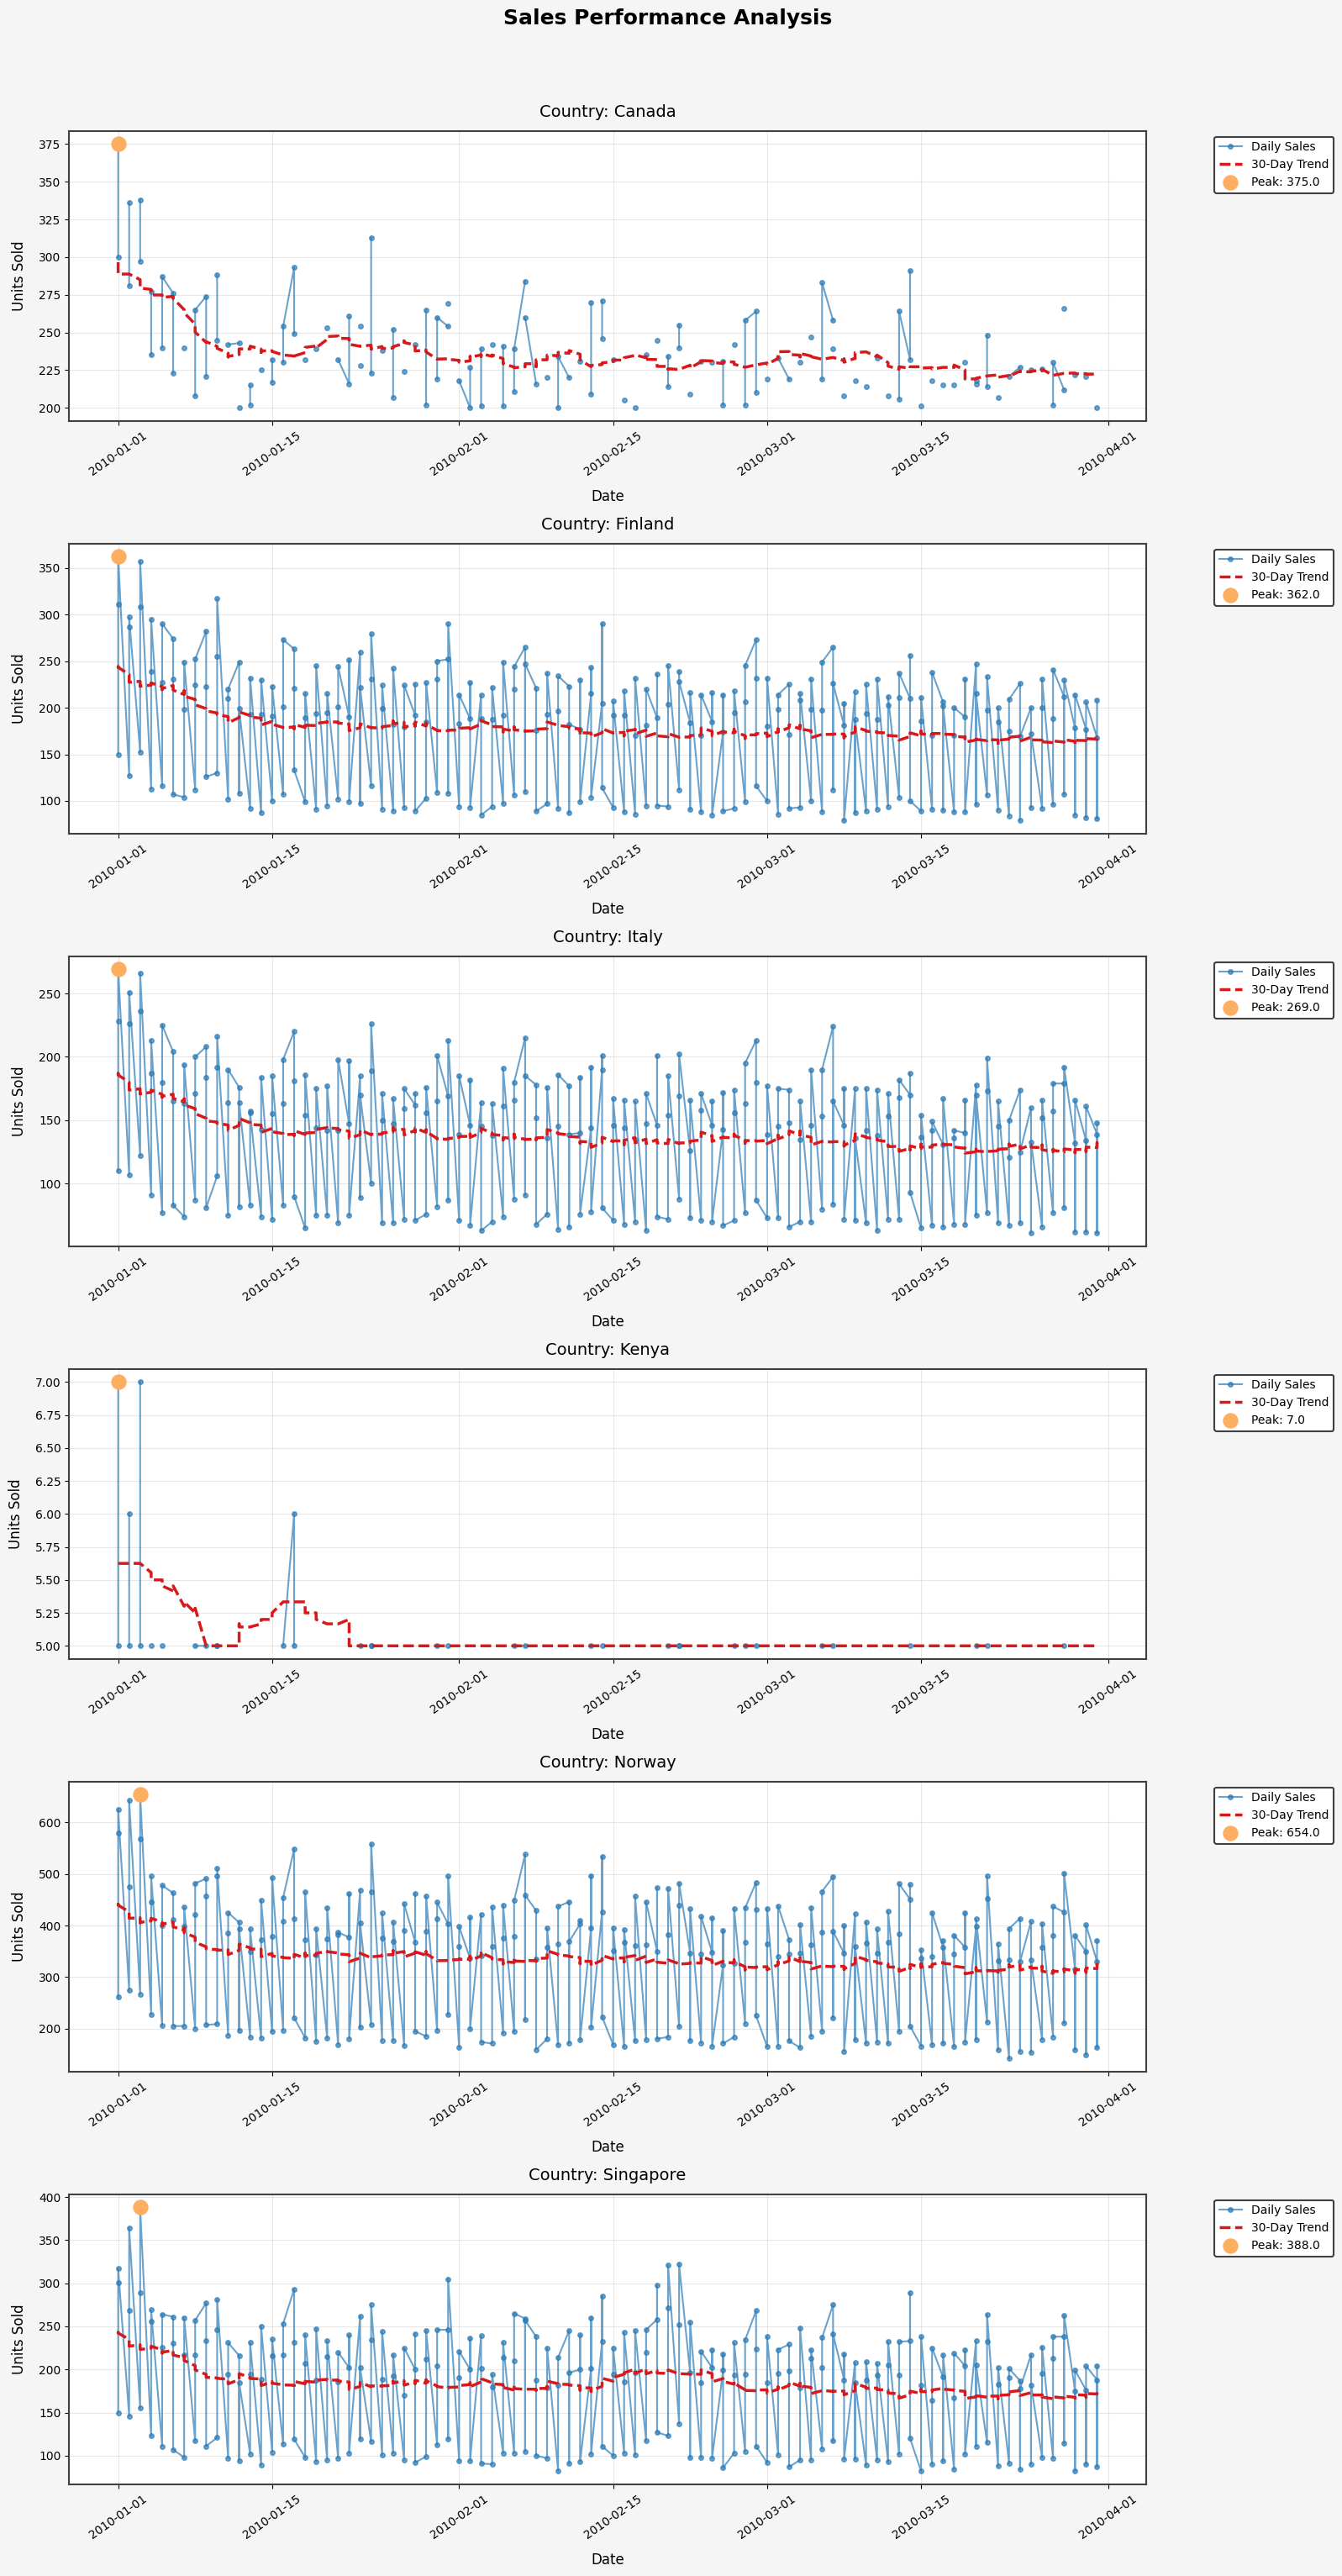

In [ ]:
df['date'] = pd.to_datetime(df['date'])
holographic_goose_sales = df[
    df['date'].between('2010-01-01', '2010-03-31') 
    & (df['product'] == 'Holographic Goose')
].copy()

target_countries = holographic_goose_sales['country'].unique()
plot_sales_trends(
    data=holographic_goose_sales,
    entities=target_countries,
    group_key='country'
)

We will analyze the distribution of NaN values across countries for product records. If Kenya and Canada emerge as primary contributors to missing data, we'll develop targeted imputation strategies to address significant noise while preserving dataset integrity.  

In [16]:
def check_countries(df: pd.DataFrame, product_name: str) -> dict:
    """
    Analyze and return country distribution for product's NaN records
    
    Args:
        df: Input DataFrame
        product_name: Target product name
        
    Returns:
        Dictionary with product name and associated countries
    """
    kerneler_mask = df['product'] == product_name
    nan_mask = df[kerneler_mask].isna().any(axis=1)
    nan_indices = df[kerneler_mask][nan_mask].index
    kerneler_df = df.loc[nan_indices]
    unique_countries = kerneler_df['country'].unique()
    
    return {
        'product': product_name,
        'countries': ', '.join(unique_countries) if len(unique_countries) > 0 else 'No NaN records',
        'nan_count': len(nan_indices)
    }

table_data = []
for product in ['Holographic Goose', 'Kerneler Dark Mode', 'Kerneler']:
    result = check_countries(df, product)
    table_data.append([
        result['product'],
        result['countries'],
        result['nan_count']
    ])

print(tabulate(
    table_data,
    headers=["Product", "Countries with NaN", "NaN Records"],
    tablefmt="pretty",
    stralign="left",
    numalign="center"
))

+--------------------+--------------------+-------------+
| Product            | Countries with NaN | NaN Records |
+--------------------+--------------------+-------------+
| Holographic Goose  | Canada, Kenya      | 8806        |
| Kerneler Dark Mode | Kenya              | 1           |
| Kerneler           | Kenya, Canada      | 64          |
+--------------------+--------------------+-------------+


The observed trend during the initial three-month period demonstrates substantial NaN prevalence in Canadian and Kenyan records. While Canada's heterogeneous dataset allows for conventional imputation methods, Kenya's limited data density raises concerns about noise amplification. To optimize outcomes we will:  
1. Implement multiple imputation approaches (mean, median, forward-fill)
2. Evaluate performance of baseline temporal models (ARIMA, Prophet)  
3. Quantify noise introduction using RMSE and MAE metrics

In [18]:
def spline_interpolation(series: pd.Series) -> pd.Series:
    """Cubic spline interpolation for replacing NaN values"""
    valid = series.dropna()
    return series if len(valid) < 2 else pd.Series(CubicSpline(valid.index, valid)(series.index), index=series.index)

def fill_na(df: pd.DataFrame, country: str, product: str, method: str, window: int = 3, order: int = 2) -> pd.Series:
    """Fill NaN values"""
    data = df.loc[(df['country'] == country) & (df['product'] == product), 'num_sold']
    methods = {
        'rolling_mean': data.rolling(window, min_periods=1, center=True).mean(),
        'rolling_median': data.rolling(window, min_periods=1, center=True).median(),
        'linear': data.interpolate(method='linear'),
        'polynomial': data.interpolate(method='polynomial', order=order),
        'spline': spline_interpolation(data)
    }
    return methods.get(method, data)

def execute_imputation(df: pd.DataFrame, methods: list, countries: list) -> pd.DataFrame:
    """Main process of replacing NaN counts"""
    for method in methods:
        df[f'filling_{method}'] = df['num_sold']
        for country in countries:
            for product in df['product'].unique():
                df.loc[(df['country'] == country) & (df['product'] == product), f'filling_{method}'] = fill_na(df, country, product, method)
    return df

In [ ]:
methods = ['rolling_mean', 'rolling_median', 'linear', 'polynomial', 'spline']
countries = ['Kenya', 'Canada']
df = execute_imputation(df, methods, countries)

print("\n✅ Imputation Results:")
print(f"Original missing values: {df['num_sold'].isna().sum()}")

print("\n" + tabulate(
    [[method, df[f'filling_{method}'].isna().sum()] for method in methods],
    headers=["Imputation Method", "Missing Values"],
    tablefmt="pretty",
    stralign="center",
    numalign="center"
))



✅ Imputation Results:
Original missing values: 8871

+-------------------+----------------+
| Imputation Method | Missing Values |
+-------------------+----------------+
|   rolling_mean    |      3061      |
|  rolling_median   |      3061      |
|      linear       |       2        |
|    polynomial     |       2        |
|      spline       |       0        |
+-------------------+----------------+


We adjusted the values to prevent noise after replacement, as it was found that the columns filled using `rolling_mean` and `rolling_median` were not suitable for our task. After substitutions, we observed that linear interpolation and a third-degree polynomial still resulted in two NaN values. To avoid data loss, we filled them using the median value, which is not critical. Next, we will conduct an analysis using a model to determine which data best handles the time series task.

In [ ]:
df.drop(columns=['filling_rolling_mean', 'filling_rolling_median'], inplace=True)
df['filling_linear'] = df['filling_linear'].fillna(df['filling_linear'].median())
df['filling_polynomial'] = df['filling_polynomial'].fillna(df['filling_polynomial'].median())
filling_list = [col for col in df.columns if col.startswith('filling_')]
df.loc[df['num_sold'].notna(), filling_list] = df.loc[df['num_sold'].notna(), 'num_sold']

methods = ['linear', 'polynomial', 'spline']
print("\n" + tabulate(
    [[method, df[f'filling_{method}'].isna().sum()] for method in methods],
    headers=["Imputation Method", "Missing Values"],
    tablefmt="pretty",
    stralign="center",
    numalign="center"
))


+-------------------+----------------+
| Imputation Method | Missing Values |
+-------------------+----------------+
|      linear       |       0        |
|    polynomial     |       0        |
|      spline       |       0        |
+-------------------+----------------+


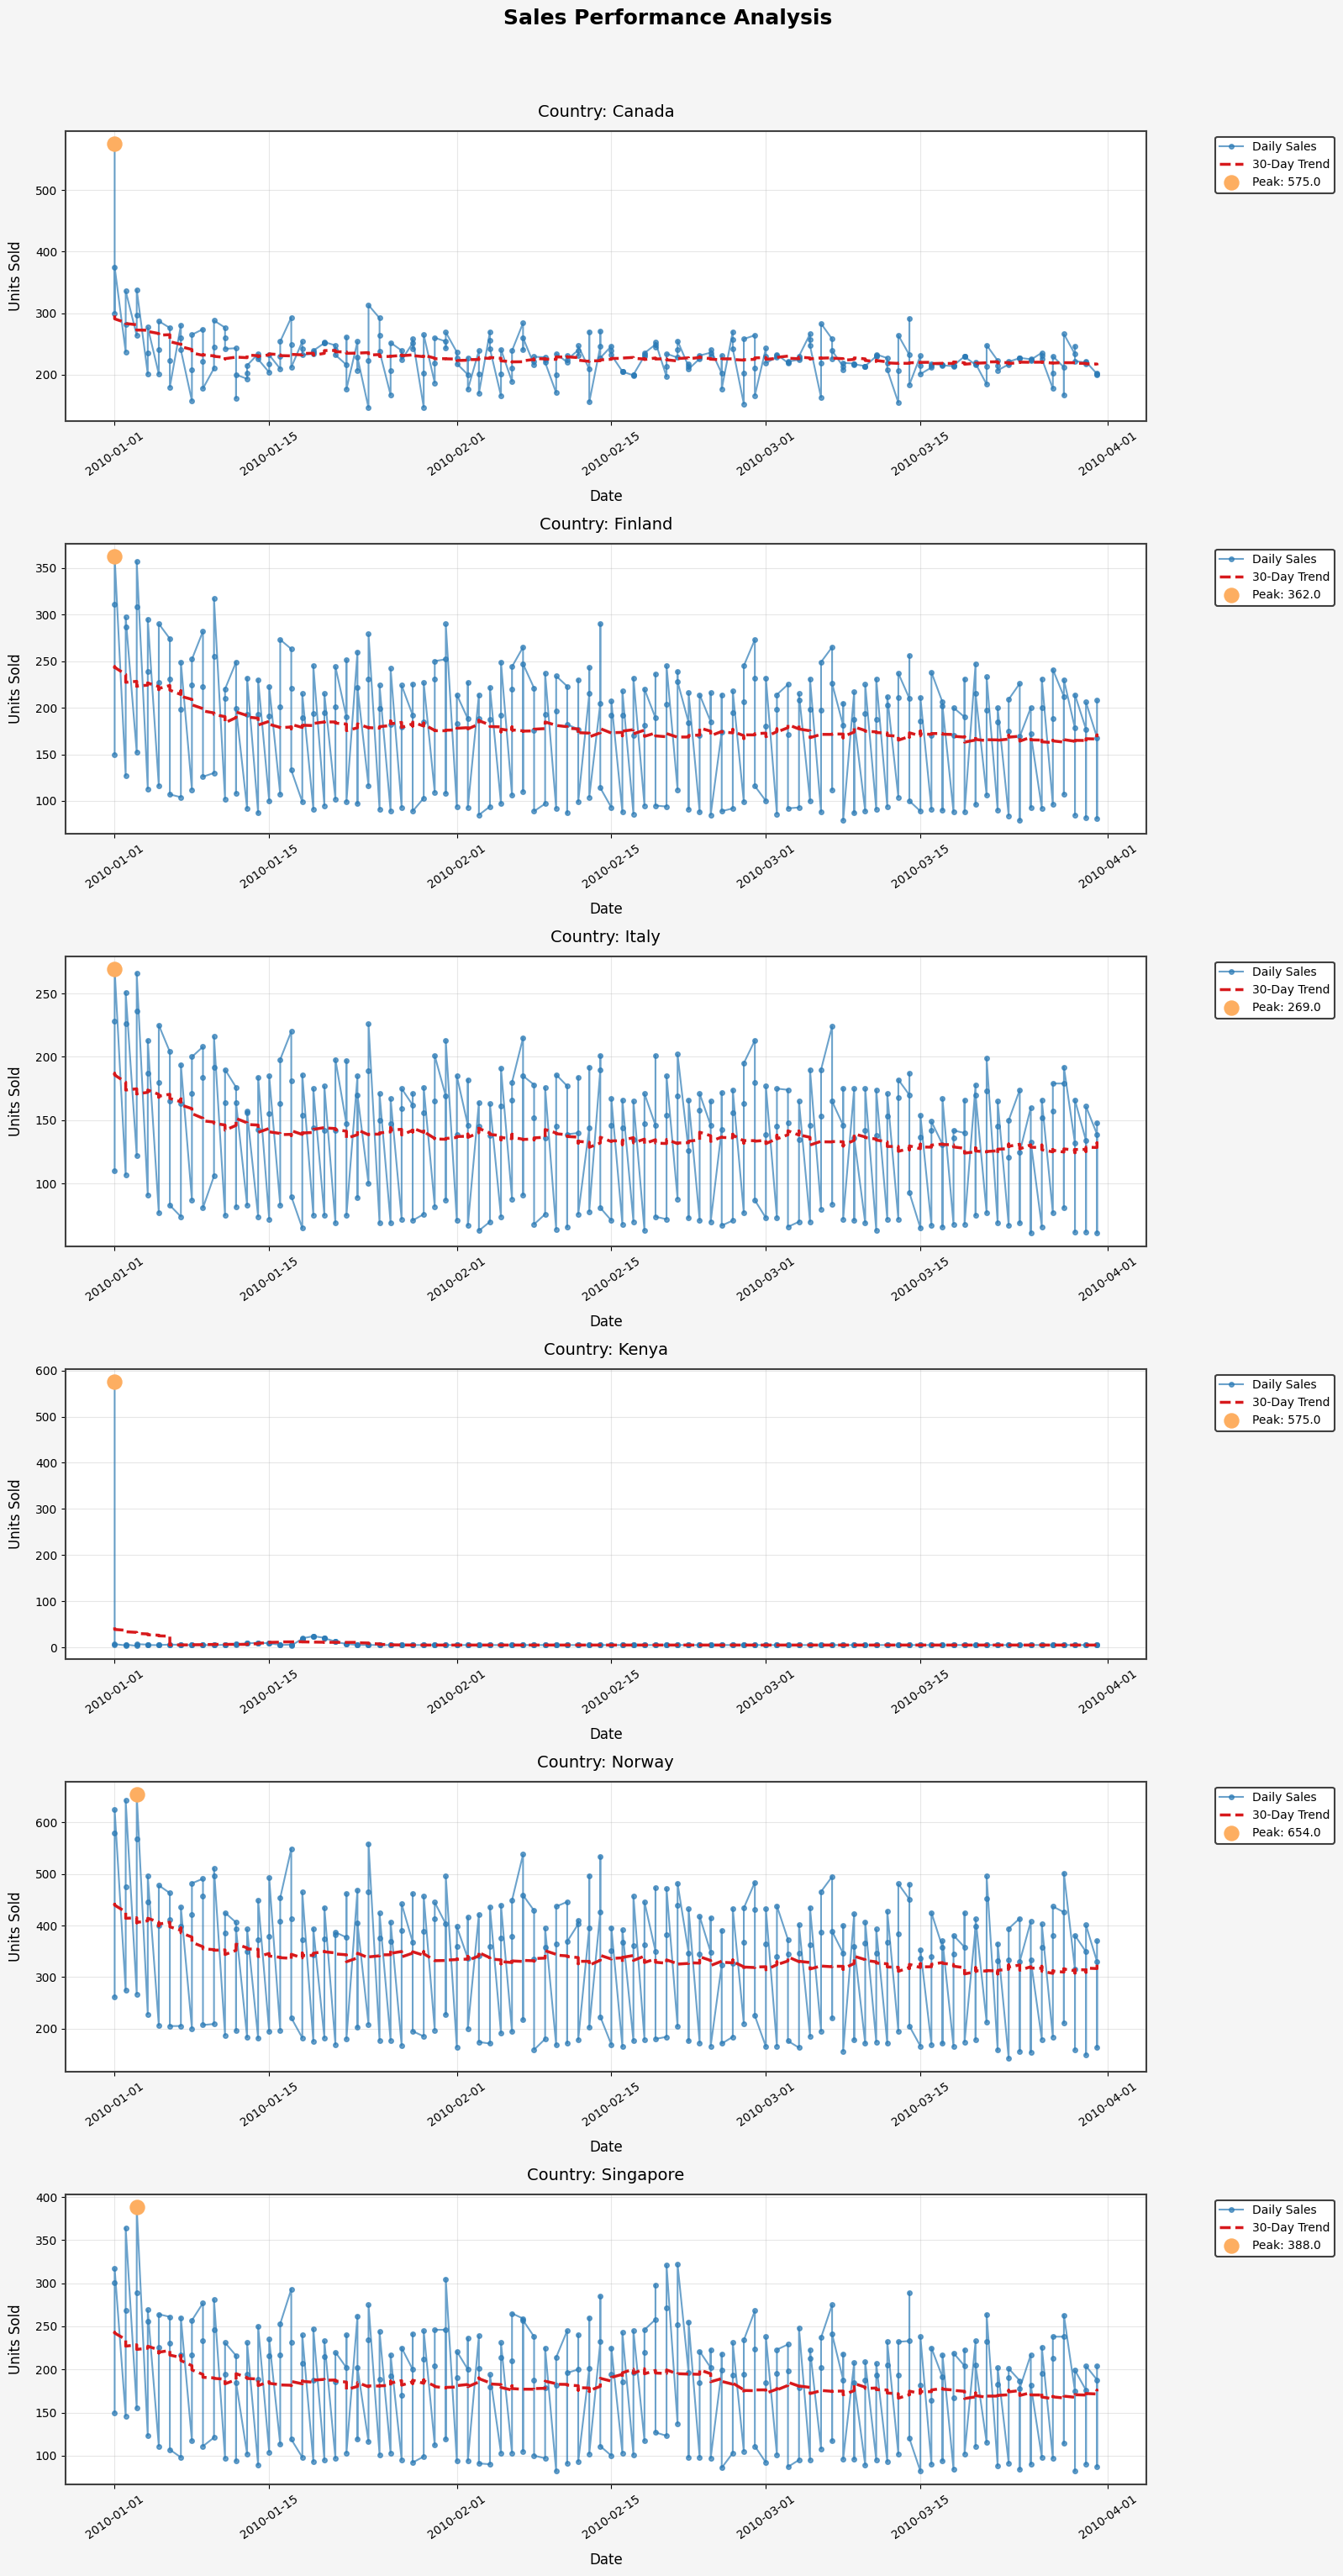

In [ ]:
filtered_df = df[
    (df['date'].dt.year == 2010) & 
    (df['date'].dt.month <= 3) & 
    (df['product'] == 'Holographic Goose')
]

plot_sales_trends(data=filtered_df, entities=target_countries, value_column='filling_polynomial', group_key='country')

## Saving

In [46]:
df = df.drop(columns=["num_sold"])
df.to_csv("./data/data_after_eda.csv", index=False)